# Farming Yield (Not yet complete)
_From Limpe's spreadsheet_
Farming yield takes the form
$$ yield = \mathbf{U} + p\mathbf{V} $$
where
$$ p = (effectiveLevel - seedLevel)/130 $$,
and $\mathbf{U}$ and $\mathbf{V}$ are independent uniform random variables from 0 to 1
These can be convolved into a single probability density of the form
$$ \mathbf{Y}(x) = A(x) * B(x) = \int A(s)B(x-s)ds$$
In this form, the functions are of the form
$$ A(x) = \Theta(x)(1-\Theta(x-a)) $$
$$ B(x) = \Theta(x)(1-\Theta(x-p)) $$
Later we will let $p$ be the same as above, and fix $a$ to 1. There are two forms for $C(x)$ then to consider, the first is when $p < a$ and the other $p > a$.

### p < a
The integral above can be solved to yield
$$ C(x) = \frac{x}{pa} \Theta(x)(1-\Theta(x-p)) + \frac{1}{a}\Theta(x-p)(1-\Theta(x-a)) + (\frac{p+a}{pa} - \frac{x}{pa})\Theta(x-a)(1-\Theta(x-p-a))$$
Where $\Theta$ is the Heaviside step function (note, I could rewrite the above using the cases notation as below to make it easier to read.).
Now we have to account for the maximum yield (the distribution is cutoff for $x>a$). The expectation value is thus split into two regions, the mean for $x<a$ and
the additional integral for $x>a$ at $x=a$. From this we find the average to be:
$$ \langle C(x)\rangle = \int_0^1 x C(x) dx + \int_1^{1+p}C(x)dx = \frac{p}{2} - \frac{p^2}{6} + \frac{1}{2}$$

### p > a
In this case we simply flip the order in the equation above (swap $a$ and $p$) then re-evalute
$$ \langle C(x)\rangle = 1 - \frac{1}{6p} $$

## Discrete Correction
_The case above is done using continuous distributions, the Floor function actually causes the distribution to be discrete (integer number of seeds) and needs a correction term. For low number of seeds (like mushrooms) this is dramatic, but for higher numbers it is barely noticable. The following is done semi-empirically and can be refined for a a more exact solution_

Since this is a Floor function and not a Round or Ceil, we know that the correction should shift the distribution to the left (average comes down), and we know that it should be proportional to the bin-width. If we define
$$\Delta = MaxSeed - MinSeed$$
then the number of bins will be $\Delta$ and the shift should (on average) go like $1/\Delta/2$ (half a bin). Note that as $\Delta \rightarrow \infty$ then the correction goes to zero. The other thing we know is that the correction is based on taking the integral to its discrete form, and should thus follow the same form (2nd order polynomial). Finally, the correction should disappear as the users level increases ($p\rightarrow\infty$).

Now the semi-emprical guess (todo: math this later, this is actually **not** correct, but close), and including
the $MaxSeed$ and $MinSeed$
$$
\langle C(x)\rangle \simeq
\begin{cases}
0 & p<0 \\
\left( \frac{p}{2} - \frac{p^2}{6} + \frac{1}{2}  - \frac{1 - p/12 - p^2/4}{2\Delta} \right)\Delta + MinSeed & 0\leq p<1 \\
\left( 1 - \frac{1}{6p} -\frac{1-1/12-1/4}{2p\Delta}\right)\Delta + MinSeed & p \geq 1
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

In [2]:
## Farming function from Limpe
def farmingYield(elvl, seed, minY, maxY):
    lDiff = elvl - seed
    if lDiff < 0:
        return 0
    bonus = lDiff/130 * np.random.rand()
    chanceForOne = 1 / (maxY - minY)
    itemAmount = min( minY + np.floor((np.random.rand()+bonus) / chanceForOne), maxY )
    #itemAmount = min( minY + ((np.random.rand()+bonus) / chanceForOne), maxY )
    return itemAmount

def wiki(elvl, seed, minY, maxY):
    lDiff = elvl - seed
    chanceForOne = 1 / (maxY - minY)
    itemAmount = min( minY + np.floor(np.random.rand()*(1+lDiff/130) / chanceForOne), maxY )
    return itemAmount

def avgF(elvl, seed, minY, maxY, **kwargs):
    trials = kwargs.get("trials", 10_000)
    x = np.array([farmingYield(elvl, seed, minY, maxY) for a in range(trials)])
    return np.mean(x), np.percentile(x, 16), np.percentile(x, 84)

def convolvedFunction(x,elvl,seed):
    s = (elvl - seed)/130
    q = 1.0
    a = q if s < q else s
    p = s if s < q else q
    if x < 0:
        return 0
    elif x < p:
        return x/(a*p)
    elif x < a:
        return 1/a
    elif x < a+p:
        return (p+a)/p/a - x/p/a
    else:
        return 0
    
def avgFarm(elvl, seed, minY, maxY):
    p = (elvl - seed)/130
    delta = maxY-minY
    w = 1/delta/2
    discreteCorrection = (1 - p/12 - p**2/4)*w
    continuity = (1 - 1/12 - 1/4)*w
    if p >= 0 and p < 1:
        return ( (-(p)**2/6 + p/2 + 0.5) - discreteCorrection )*delta + minY
    if p >= 1:
        return (1 - 1/6/(p) - continuity/p)*delta + minY
    return 0

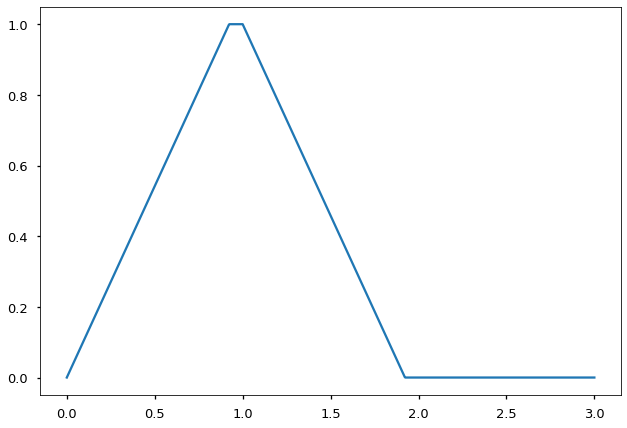

In [3]:
x = np.linspace(0, 3, 1000)
plt.plot(x, [convolvedFunction(a,150,30) for a in x])
plt.show()

Limpe: 42.54159, Wiki (old): 39.36642


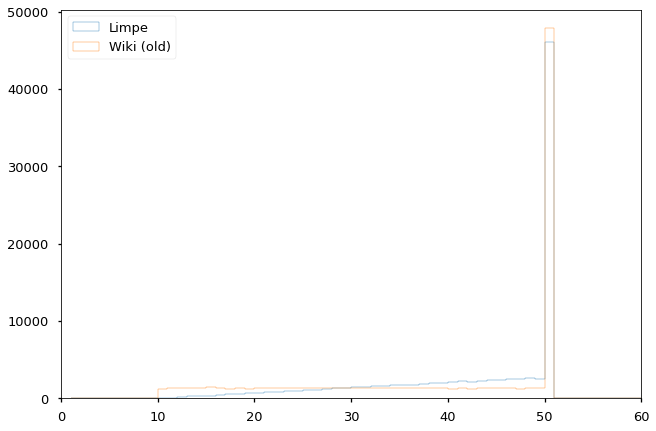

In [4]:
x = [farmingYield(150, 30, 10, 50) for x in range(100000)]
xp = [wiki(150, 30, 10, 50) for x in range(100000)]
print(f'Limpe: {np.mean(x)}, Wiki (old): {np.mean(xp)}')
avg = np.mean(x)
up = np.percentile(x, 84)
dn = np.percentile(x, 16)
plt.hist(x, bins=np.linspace(1,100,100), label=f'Limpe', histtype='step')
plt.hist(xp, bins=np.linspace(1,100,100), label=f'Wiki (old)', histtype='step')
plt.xlim(0, 60)
plt.legend(loc=2)
plt.show()

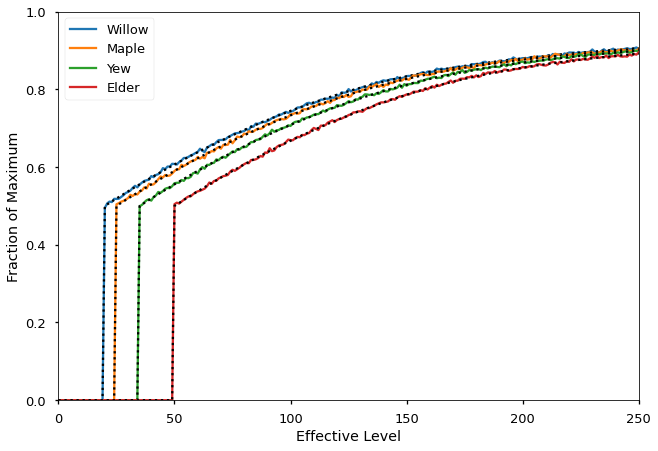

In [5]:
# Comparison of the simulation approach and the analytic equation -- infinite seed limit
def eplot(seed, name, **kwargs):
    top = kwargs.get("top", 200)
    bot = kwargs.get('bot', 0)
    y = np.linspace(bot, top, top+1-bot)
    z, low, hi = np.array([avgF(a, seed, 0, 10000) for a in y]).T/10000
    p = plt.plot(y, z, label=name)
    plt.plot(y, np.array([avgFarm(a, seed,0, 10000) for a in y])/10000, ":", color='black')
    #plt.fill_between(y, low, hi, alpha=0.15)
    plt.xlim(bot, top)

eplot(20, "Willow", top=250)
eplot(25, "Maple" , top=250)
eplot(35, "Yew"   , top=250)
eplot(50, "Elder" , top=250)
plt.xlabel("Effective Level")
plt.ylabel("Fraction of Maximum")
plt.ylim(0, 1)
plt.legend()
plt.show()

Plotted with the empirical correction, notice that at the high and low ends it works, but it is slightly off at N=4


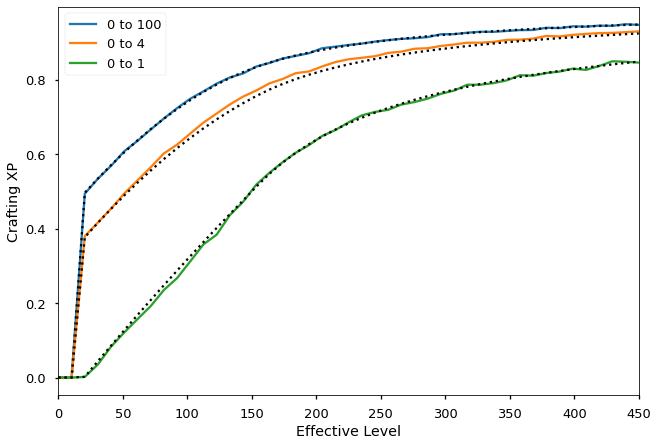

In [6]:
## Weide's Plot
def wplot(seed, name, **kwargs):
    top = kwargs.get("top", 200)
    bot = kwargs.get('bot', 0)
    minSeed = kwargs.get('low', 10)
    maxSeed = kwargs.get('high', 50)
    width = (maxSeed - minSeed)
    value = kwargs.get('value', 5) # crafting xp?
    y = np.linspace(bot, top, int((top+1-bot)/10))
    z, low, hi = np.array([avgF(a, seed, minSeed, maxSeed) for a in y]).T
    z = z*value
    p = plt.plot(y, z, label=name)
    plt.plot(y, [(avgFarm(a, seed,minSeed, maxSeed))*value for a in y], ":", color='black')
    #plt.fill_between(y, low, hi, alpha=0.15)
    plt.xlim(bot, top)

    
print("Plotted with the empirical correction, notice that at the high and low ends it works, but it is slightly off at N=4")
wplot(20, "0 to 100", top=450, low=0, high=100, value=1/100)
wplot(20, "0 to 4", top=450, low=0, high=4, value=1/4)
wplot(20, "0 to 1", top=450, low=0, high=1, value=1)
#wplot(25, "Maple",  top=250, low=0, high=4, value=50/15)
#wplot(35, "Yew",    top=250, low=0, high=4, value=50/10)
plt.xlabel("Effective Level")
plt.ylabel("Crafting XP")
plt.legend()
plt.show()